In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn import linear_model
from sklearn.metrics import r2_score, root_mean_squared_error

In [2]:
#Initialising each variable
file_prefix = "I-Z spectroscopy"
materials = ["Graphite", ]

#dictionary to hold material, mean current data frame pairs
mean_dfs = {}

#iterating over each material
for material in materials:
    #setting up data frame to hold each current value
    volt_column = False
    grand_df = pd.DataFrame({})

    #looping over 16 csv w/ the naming convention
    for i in range(1, 13):
        #storing raw spectroscopy data in data frame
        spectroscopy = pd.read_csv(f"Worthwhile Scans\\week 6\\{material} I-Z csvs\\{file_prefix} {i}.csv",
                               names=["Z (m)", "Current (A)"],
                               sep=";")

        #if statement set up to only write voltage column once
        if volt_column == False:
            grand_df["Z (m)"] = spectroscopy["Z (m)"]
            volt_column = True

        #Writing current to big data frame
        grand_df[f"Current (A) {i}"] = spectroscopy["Current (A)"]

        #calculate mean current of all 12 current
        mean_df = pd.DataFrame({"Z (m)":grand_df["Z (m)"],
                           "Mean Current (A)":grand_df.iloc[:, 1:].mean(axis=1)})
        mean_df.to_csv(f"I-Z mean spectroscopy {material}.csv", index=False)

        #write data frame of voltage and current to dictionary
        mean_dfs[material] = mean_df


72


<Axes: xlabel='Z (m)'>

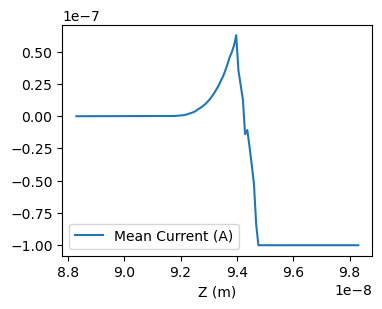

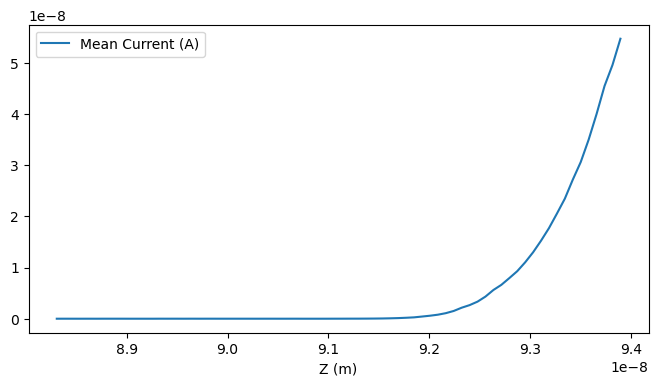

In [3]:
for material in materials:
    fig, ax = plt.subplots(figsize=(4, 3))
    mean_dfs["Graphite"].plot("Z (m)", "Mean Current (A)", ax = ax)
    max_index = np.argmax(mean_dfs["Graphite"]["Mean Current (A)"])
    print(max_index)
    
    fig, ax2 = plt.subplots(figsize=(8, 4))
    mean_dfs_trunc = mean_dfs.copy()
    mean_dfs_trunc["Graphite"] = mean_dfs_trunc["Graphite"][:max_index]
    mean_dfs_trunc["Graphite"].plot("Z (m)", "Mean Current (A)", ax = ax2)

Dynamically determined window size: 38
Index of the start of exponential growth: 42


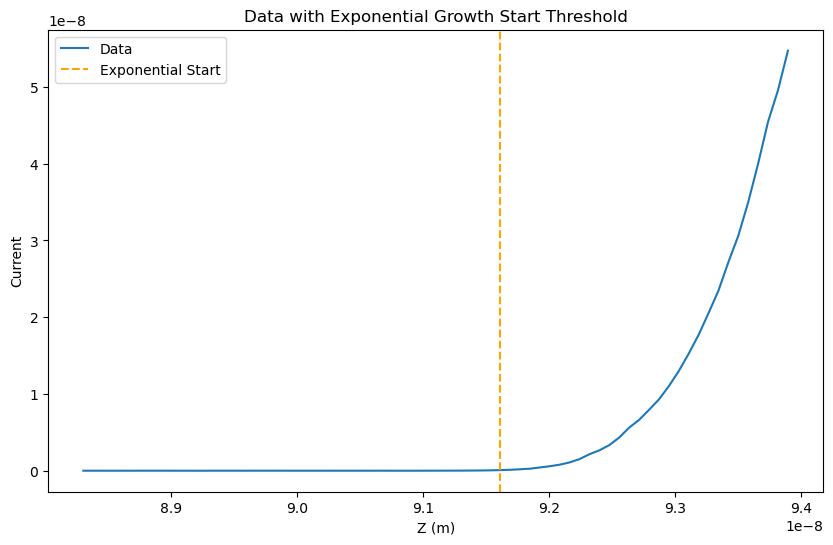

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lj22452\AppData\Local\Temp\ipykernel_12908\4222748852.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_dfs_trunc["Graphite"]["ln(Mean Current (A))"] = np.log(mean_dfs_trunc["Graphite"]["Mean Current (A)"])


In [4]:
df = mean_dfs_trunc["Graphite"]

# Parameters
initial_window = 5       # Starting size for the window
max_window = 50          # Maximum window size to prevent it from being too large
change_threshold = 50.0  # Percentage change threshold to detect start of exponential growth

# Dynamically determine the window size based on variance percentage change
window_size = initial_window
prev_variance = df["Mean Current (A)"][:window_size].var()
stable_window_found = False

while window_size < max_window and not stable_window_found:
    window_size += 1
    current_variance = df["Mean Current (A)"][:window_size].var()
    
    # Calculate the percentage change in variance
    variance_change = abs((current_variance - prev_variance) / prev_variance) * 100 if prev_variance != 0 else 0
    
    # Check if the change exceeds the threshold
    if variance_change > change_threshold:
        stable_window_found = True
    prev_variance = current_variance
print("Dynamically determined window size:", window_size)

# Calculate rolling mean and std dev with the dynamically determined window
rolling_mean = df["Mean Current (A)"].rolling(window=window_size, min_periods=1).mean()
rolling_std = df["Mean Current (A)"].rolling(window=window_size, min_periods=1).std()

# Define the threshold: rolling mean + 3 * rolling std deviation
threshold = rolling_mean + 4.75 * rolling_std

# Find the index where the data first exceeds the threshold
exponential_start_index = np.argmax(df["Mean Current (A)"] > threshold)

print("Index of the start of exponential growth:", exponential_start_index)

plt.figure(figsize=(10, 6))
plt.plot(df["Z (m)"], df["Mean Current (A)"], label="Data")
plt.axvline(x=df["Z (m)"][exponential_start_index], color = "orange", linestyle="--", label="Exponential Start")
plt.xlabel("Z (m)")
plt.ylabel("Current")
plt.title("Data with Exponential Growth Start Threshold")
plt.legend()
plt.show()

# Truncating the data frame accordingly and then plotting the fit.
mean_dfs_trunc["Graphite"]["ln(Mean Current (A))"] = np.log(mean_dfs_trunc["Graphite"]["Mean Current (A)"])
mean_dfs_trunc["Graphite"] = mean_dfs_trunc["Graphite"][exponential_start_index:]

Line gradient from model:  [2.76605853e+09]
Line intercept from model: -275.7705252988167 

r2_score: 0.9517340795051173
ROOT mean squared error: 0.42453094667806773 

Final Work Function (eV):  4.317749903414008  ±  0.4245309466780678  eV


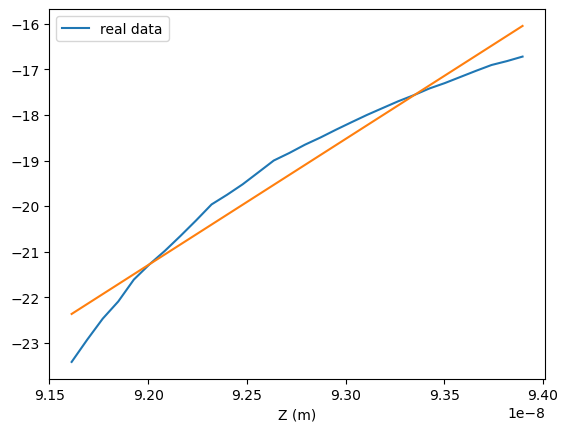

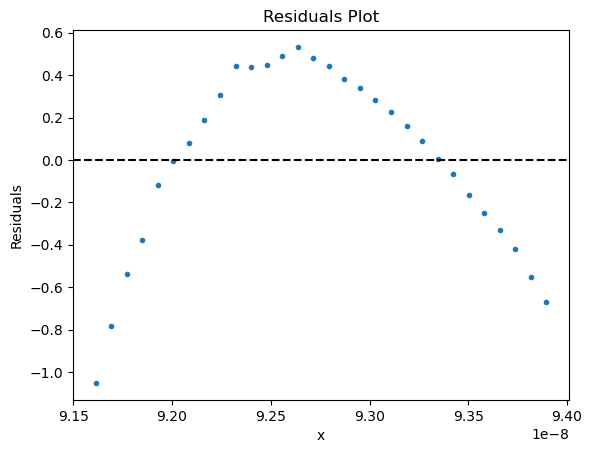

In [11]:
model = linear_model.LinearRegression(fit_intercept=True)

X = mean_dfs_trunc["Graphite"][["Z (m)"]]
Y = mean_dfs_trunc["Graphite"]["ln(Mean Current (A))"]

model.fit(X,Y)
prediction = model.predict(X)

print("Line gradient from model: ", model.coef_)
print("Line intercept from model:", model.intercept_, "\n")

fig, ax = plt.subplots()
mean_dfs_trunc["Graphite"].plot("Z (m)", "ln(Mean Current (A))", ax = ax, label = "real data")
ax.plot(mean_dfs_trunc["Graphite"]["Z (m)"], prediction, label = "regression line")

fig1, ax1  = plt.subplots()

# Create a plot of residuals
ax1.plot(mean_dfs_trunc["Graphite"]["Z (m)"], (Y - prediction),'.')

# Add a horizontal line at zero to guide the eye
ax1.axhline(0, color='k', linestyle='dashed')

# Add axis labels
ax1.set_title("Residuals Plot")
ax1.set_xlabel("x")
ax1.set_ylabel("Residuals")

print(f"r2_score: {r2_score(Y,prediction)}")
print(f"ROOT mean squared error: {root_mean_squared_error(Y,prediction)}", "\n")

error_work_func = np.std((Y - prediction))
print("Final Work Function (eV): ", str((model.coef_[0] / 1.0250E-10) * 1.6E-19), " \u00B1 ", error_work_func, " eV")